# Importing the Libraries

In [19]:

#Import Standard Data Analysis Libraries
import datetime
import numpy as np
import pandas as pd

import re
import scipy.io

#Import dill library to save variables generated
import dill
import pickle
import path
import os

#import a plotting component
import matplotlib.pyplot as plt

#system
import platform



# Setting the Directory

In [11]:
import sys
sys.path.append('Code Files')
sys.path.append('Data')

In [13]:

#n_train: number of training data samples
#n_test: number of test data samples
#tensor_dimensions: The dimensionality of the tensor.
#tensor_mode_ranks: Ranks along each mode of tensor
#separation_rank: S for LSR Decomposition

### CODE FOR DATA GENERATION

import numpy as np

#n_train: number of training data samples
#n_test: number of test data samples
#tensor_dimensions: The dimensionality of the tensor.
#tensor_mode_ranks: Ranks along each mode of tensor
#separation_rank: S for LSR Decomposition
#if intercept =! 0 then the synthetic data is not centered

def generate_data(n_train, n_test, tensor_dimensions: np.ndarray,\
                  tensor_mode_ranks: np.ndarray, separation_rank, intercept = 0):

    #Calculate number of tensor dimensions
    D = len(tensor_dimensions)

    #generating the training and testing together
    output_tensor_shape = tuple(np.append(n_train + n_test , tensor_dimensions))

    #Generate Core Tensor
    size = np.prod(tensor_mode_ranks)
    G1 = np.random.normal(0, 1/size, size)
    G1 = G1.reshape(tensor_mode_ranks)
    #G1 = G1 / np.linalg.norm(G1, ord = 'fro')

    #generating the factor matrices
    all_factor_matrices=[]
    for s in range (separation_rank):
        mode_s_factormatrices = []
        for k in range(D):
            dummy_mat = np.random.normal(0, 1, size = (tensor_dimensions[k], tensor_mode_ranks[k]) )
            mode_s_factormatrices.append(dummy_mat)
        all_factor_matrices.append(mode_s_factormatrices)

    print('Initiallizng Core Tensor and Factor Matrices: Done')

    #Using the Factor Matrices and Core Tensor, Generate B
    B_tensor_prior_N = np.zeros(tensor_dimensions)
    for s in range(separation_rank):
        B_tensor_prior_N += all_factor_matrices[s][0] @ G1 @ all_factor_matrices[s][1].T

    # Normalizing

    #norms = np.linalg.norm(B_tensor_prior_N, ord = 'fro')
    B_tensor = B_tensor_prior_N #/norms

    print('Generating the Parameter Tensor: Done')

    #Generate X
    X = np.random.normal(5,1,size=(output_tensor_shape))

    #generating the dependent variable
    B_tensor_flatten = B_tensor.flatten(order ='F')
    X_transpose = np.transpose(X, (0,2,1))
    X_transpose_vectorized = np.reshape(X_transpose, newshape = (X_transpose.shape[0],-1))
    y_no_noise = np.dot(X_transpose_vectorized, B_tensor_flatten) + intercept
    y = y_no_noise + np.random.normal(0, 1, size = y_no_noise.shape)
    print('Generating Data: Done')
    if intercept != 0:
       print('Data generated with an intercept')

    #Split into X_train, X_test, Y_train,Y_test
    X_train = X[:n_train]
    X_test  = X[n_train:n_train+n_test]
    y_train = y[:n_train]
    y_test  = y[n_train:n_train+n_test]
    print('Splitting into Train/Test: Done')

    return X_train, y_train, X_test, y_test, B_tensor,G1,all_factor_matrices,y_no_noise

In [14]:
# Function to mean and the energy


def mean_energy(A):
  mean    = np.mean(A)
  energy  = np.sum((A-mean)**2)/(np.size(A)-1)  # cause we are calculating the energy of a sample from the population we use n-1
  return mean, energy


In [16]:
n_train = 5000
n_test = 1000

tensor_dimensions = np.array([32, 32])
tensor_mode_ranks = np.array([4, 4])
separation_rank = 2
intercept = 0


X_train_all, Y_train_all, X_test, Y_test, B_tensored,G1,all_factormatrices,Y_train_nonoise = generate_data(n_train, n_test, tensor_dimensions, tensor_mode_ranks, separation_rank, intercept= intercept)



Initiallizng Core Tensor and Factor Matrices: Done
Generating the Parameter Tensor: Done
Generating Data: Done
Splitting into Train/Test: Done


In [28]:
#saving the data neededz
formatted_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

if platform.system() == "Windows":
    pkl_file = rf"D:\Tensor Based ML for Neuro Imaging\INSPIRE_CAHBHIR\Python Scripts\LSR-Tensor-Ridge-Regression\Data_Sets\Synthetic Data\Uncentered X\ n_train_{n_train}_ntest_{n_test}_tensordim_{tensor_dimensions}_tensor_ranks_{tensor_mode_ranks}_seprank_{separation_rank}.pkl"
elif platform.system() == "Darwin":
    pkl_file = f"/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Stochastic LSR TRR/Experimental Results/ExecutionTime_intercept_5_{formatted_time}, n_train_{n_train},n_test_{n_test}, tensor_dimensions:{tensor_dimensions}, tensor_mode_ranks:{tensor_mode_ranks}, separation_rank:{separation_rank}, max_iter={max_iter}.pkl"


with open(pkl_file, "wb") as file:
    dill.dump((X_train_all, Y_train_all, X_test, Y_test, B_tensored,G1,all_factormatrices,Y_train_nonoise), file)

### When reusing the data do it from here.

In [30]:
import pickle

file= open(rf"D:\Tensor Based ML for Neuro Imaging\INSPIRE_CAHBHIR\Python Scripts\LSR-Tensor-Ridge-Regression\Data_Sets\Synthetic Data\Uncentered X\ n_train_5000_ntest_1000_tensordim_[32 32]_tensor_ranks_[4 4]_seprank_2.pkl", 'rb')
data = pickle.load(file)

file.close()

X_train = data[0]
print(data[0].shape)

Y_train = data[1]
print(data[1].shape)

X_test = data[2]
print(data[2].shape)

Y_test = data[3]
print(data[3].shape)

B_tensored = data[4]
print(data[4].shape)

G1 = data[5]
print(data[5].shape)

all_factormatrices = data[6]
#print(data[6].shape)

Y_train_nonoise = data[7]
print(data[7].shape)


(5000, 32, 32)
(5000,)
(1000, 32, 32)
(1000,)
(32, 32)
(4, 4)
(6000,)


Factor Matrix 0 0
mean 0.08970641354263997 energy 0.9033662106257048



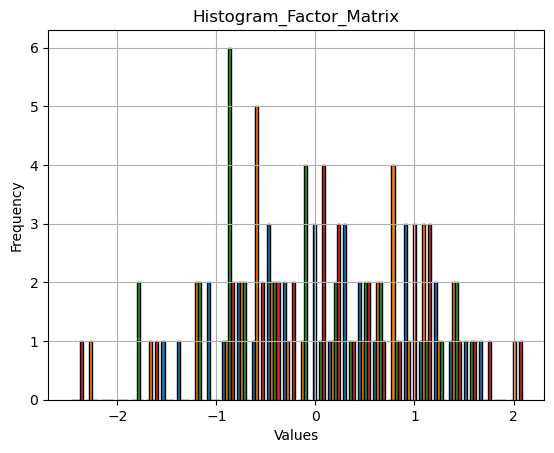

Factor Matrix 0 1
mean -0.061233346494515124 energy 0.9905324424037095



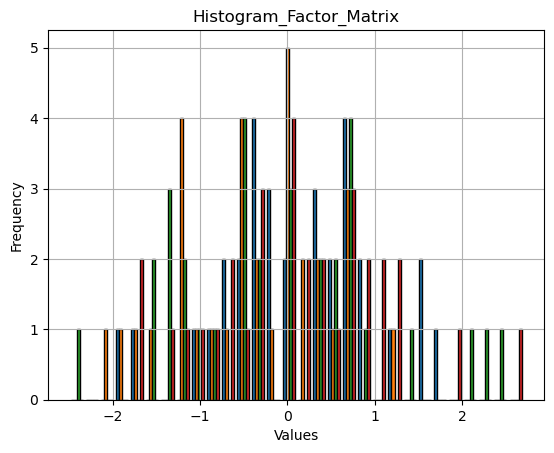

Factor Matrix 1 0
mean -0.014153171148213815 energy 1.0208659838239609



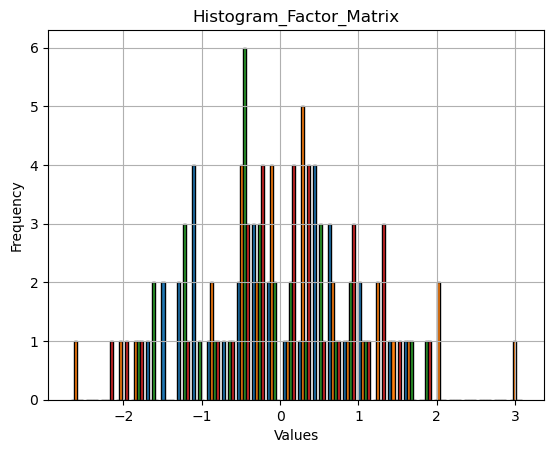

Factor Matrix 1 1
mean 0.05334813394083996 energy 0.8781921254912377



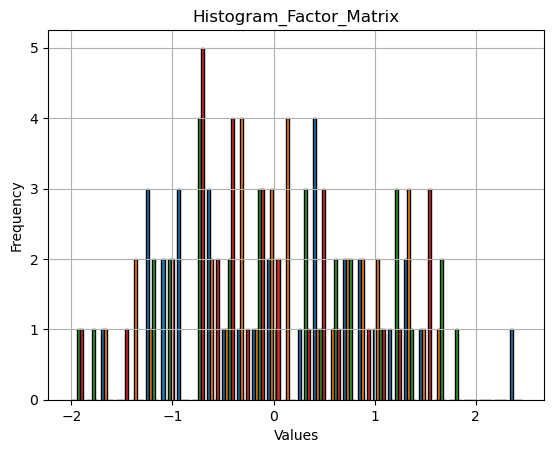

Core Tensor
mean 0.011657333736240283 energy: 0.004141743823921235



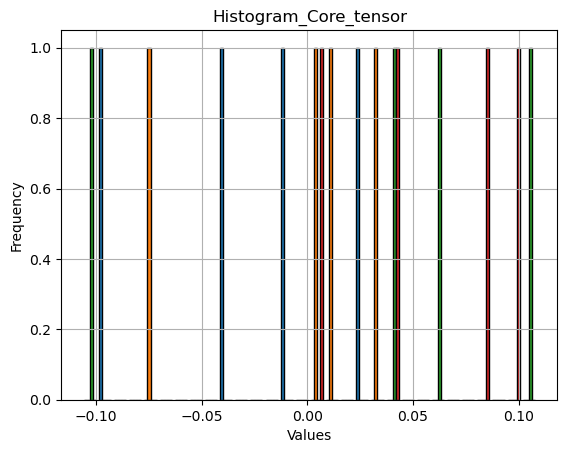

In [31]:
#factor to numpy

#all_fac_nd = []
#for s, term_s_factors in enumerate(all_factormatrices):
#  for k, term_k_factors in enumerate(term_s_factors):
#            term_s_factors_ndarray = [param.data.numpy() for param in term_s_factors]
#  all_fac_nd.append(term_s_factors_ndarray)

for s,term_s_factors in enumerate(all_factormatrices):
  for k,factor in enumerate(term_s_factors):
    print('Factor Matrix',s,k)
    Fac_mean, Fac_energy = mean_energy(factor)
    print('mean',Fac_mean,'energy',Fac_energy)
    print('')
    # Plot the histogram
    plt.hist(factor, bins=30, edgecolor='black')  # Adjust the number of bins as needed
    plt.title('Histogram_Factor_Matrix')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

#core tensor

print('Core Tensor')
mean_G,energy_G = mean_energy(G1)
print('mean',mean_G,'energy:',energy_G)
print('')

# Plot the histogram
plt.hist(G1, bins=30, edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram_Core_tensor')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()



2085.8982931691
LSR Tensor
mean 0.016163894250458895 energy: 2.0387397372202387



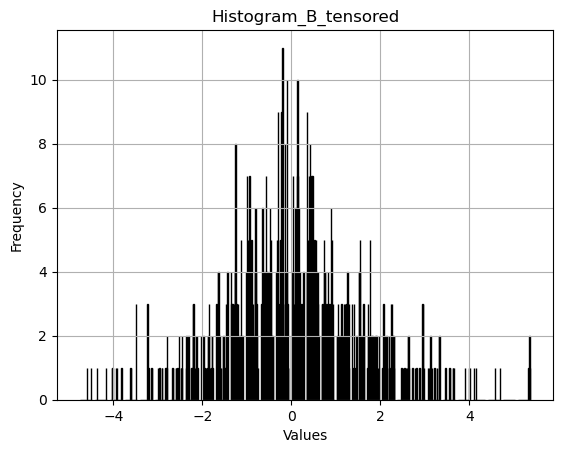

In [24]:

Norm_B = np.linalg.norm(B_tensored, ord = 'fro')
print(Norm_B**2)

print('LSR Tensor')
mean_B_ten,energy_B_ten = mean_energy(B_tensored)
print('mean',mean_B_ten,'energy:',energy_B_ten)
print('')

# Plot the histogram
plt.hist(B_tensored, bins=30, edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram_B_tensored')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [32]:
#samples

for i in range (800):
    print('Sample',i)
    Fac_mean, Fac_energy = mean_energy(X_train_all[i,:,:])
    print('mean',Fac_mean,'energy',Fac_energy)
    print('')


All_mean, All_energy = mean_energy(X_train_all )
print('mean',All_mean,'energy:',All_energy)

Sample 0
mean 4.996193733367964 energy 0.9630415754201272

Sample 1
mean 5.073591947026373 energy 1.0501429810391834

Sample 2
mean 5.03536858331014 energy 1.0348403644552557

Sample 3
mean 5.043334297431391 energy 0.9719555915883294

Sample 4
mean 4.924032672110101 energy 0.9583601861998289

Sample 5
mean 5.025500485336976 energy 1.1047586096732784

Sample 6
mean 4.996135465081504 energy 0.9972169182459631

Sample 7
mean 5.018718944206118 energy 1.006504652296359

Sample 8
mean 4.976118608975486 energy 1.0478265402407687

Sample 9
mean 4.994281249743487 energy 0.9687608377810732

Sample 10
mean 4.960848845506319 energy 0.9627072496940198

Sample 11
mean 4.9710553489137395 energy 0.9552850263882482

Sample 12
mean 4.982899394035482 energy 0.9991370329310333

Sample 13
mean 4.996807699611198 energy 1.0821809605117185

Sample 14
mean 5.053926481921028 energy 0.941246706551945

Sample 15
mean 4.9509033023028275 energy 0.9844127573400954

Sample 16
mean 5.034500049930406 energy 1.047718164

<B,X>_training
mean -11.395356332760134 energy: 129.73504189335156



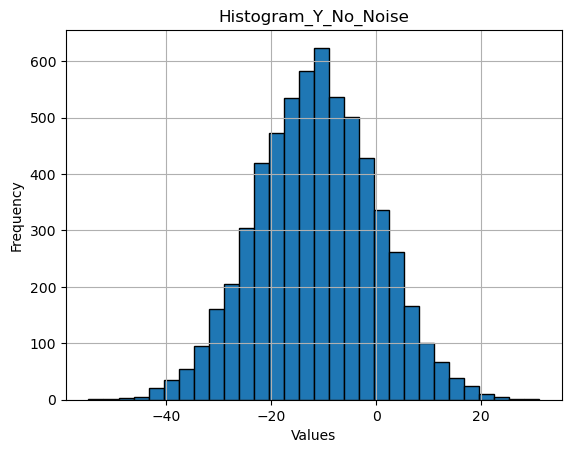

In [35]:
#No_noise

print('<B,X>_training')
mean_T_train_no,energy_T_train_no = mean_energy(Y_train_nonoise)
print('mean',mean_T_train_no,'energy:',energy_T_train_no)
print('')

# Plot the histogram
plt.hist(Y_train_nonoise, bins=30, edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram_Y_No_Noise')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

training
mean -11.315134994150087 energy: 129.4736220758092



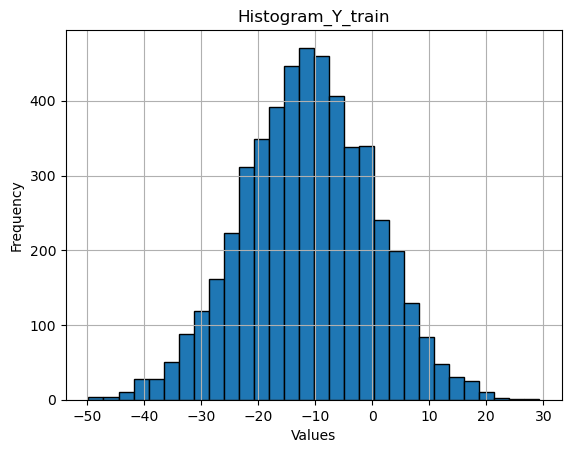

In [36]:
#training
Y_train = Y_train_all
print('training')
mean_Y,energy_Y = mean_energy(Y_train)
print('mean',mean_Y,'energy:',energy_Y)
print('')

# Plot the histogram
plt.hist(Y_train, bins=30, edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram_Y_train')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#still we have the error of mean shift and variance

testing
mean -11.764261101139768 energy: 136.58099817798072



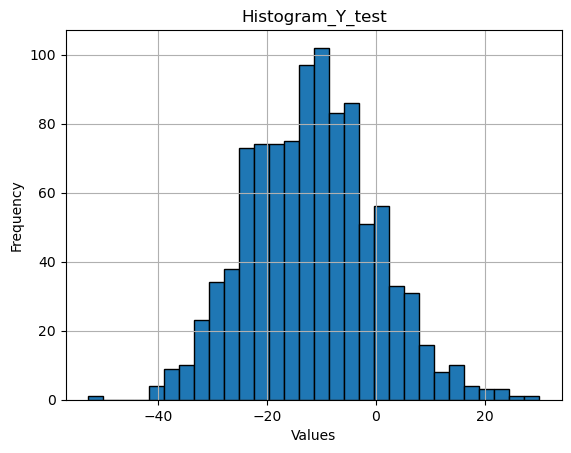

In [37]:
#testing
print('testing')
mean_Y_test,energy_Y_test = mean_energy(Y_test)
print('mean',mean_Y_test,'energy:',energy_Y_test)
print('')

# Plot the histogram
plt.hist(Y_test, bins=30, edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram_Y_test')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()